#Load The Data

In [1]:
from google.colab import drive
drive.mount('content/')

Mounted at content/


In [2]:
import os
os.chdir('content/MyDrive/Traffic Sign')

In [3]:
!ls

models		    test.p			   train.p
Project_Hack.ipynb  Traffic_Sign_Classifier.ipynb  utils.py
__pycache__	    traffic-signs-data.zip	   valid.p
signnames.csv	    Training.zip


In [4]:
# Visualizations will be shown in the notebook.
%matplotlib inline
from importlib import reload
import utils; reload(utils)
from utils import *

In [5]:
# Import crucial modules
import pickle
%tensorflow_version 1.x
import tensorflow as tf
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
import cv2
import matplotlib.pyplot as plt

from sklearn.utils import shuffle
import time

TensorFlow 1.x selected.


In [6]:
datasets_path = "./"
models_path = "./models/"

training_file = datasets_path + 'train.p'
validation_file= datasets_path + 'valid.p'
testing_file = datasets_path + 'test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

# Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image.


## Provide a Basic Summary of the Data Set Using Python, Numpy and/or Pandas

In [7]:
# Let's get some dimensions
print("Features shape: ", X_train.shape)
print("Leatures shape: ", y_train.shape)

Features shape:  (34799, 32, 32, 3)
Leatures shape:  (34799,)


In [8]:
# Number of training examples
n_train = X_train.shape[0]

# Number of validation examples
n_validation = X_valid.shape[0]

# Number of testing examples.
n_test = X_test.shape[0]

# What's the shape of an traffic sign image?
image_shape = X_train.shape[1:]

# How many unique classes/labels there are in the dataset.
n_classes = len(set(y_train))

print("Number of training examples =", n_train)
print("Number of validation examples =", n_validation)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of validation examples = 4410
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


### Group the images by class

We leverage on the pandas module to group the images by label. Our first step is to import the signnames.csv file which contains English description of the labels.

In [9]:
# Load sign names file
sign_names = pd.read_csv("signnames.csv")
sign_names.set_index("ClassId")

sign_names.head(n=3)

ClassId              SignName
0        0  Speed limit (20km/h)
1        1  Speed limit (30km/h)
2        2  Speed limit (50km/h)

#### Group Images In Training set

In [10]:
X_train_id_to_label = group_img_id_to_lbl(y_train, sign_names)

# Let's print a few of those mappings now
X_train_id_to_label.head(n=3)

img_id  label_id                   label_name
0       0        15                  No vehicles
1       1         8        Speed limit (120km/h)
2       2         6  End of speed limit (80km/h)

In [11]:
# We should group by label id to understand the distribution
X_train_group_by_label_count = group_img_id_to_lb_count(X_train_id_to_label)
X_train_group_by_label_count.head(n=5)

img_id
label_id label_name                  
0        Speed limit (20km/h)     188
1        Speed limit (30km/h)    1971
2        Speed limit (50km/h)    1975
3        Speed limit (60km/h)    1239
4        Speed limit (70km/h)    1768

We can already witness siginificant data imbalance across the classes in the training. For instance class 0 has less than 200 images, while class 2 has over 2000 images. Let's plot the number of images against the class to better understand visually where we stand.

#### Training Set Distribution Visualization

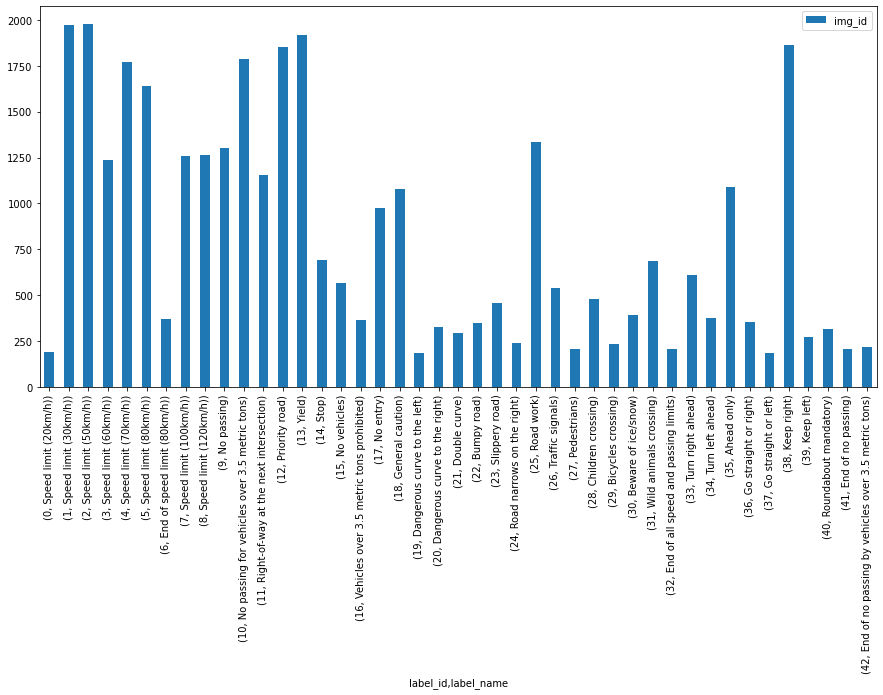

In [12]:
# Now count the number of images for each class and plot the results so that we understand the distribution
X_train_group_by_label_count.plot(kind='bar', figsize=(15, 7))

This confirms the significant class imbalance we observed earlier. At this stage we will not attempt to address it.

#### Training Set Image Visualization

In [13]:
# Let's plot images from each of these classes
X_train_group_by_label = X_train_id_to_label.groupby(["label_id", "label_name"])
img_per_class = 5

show_random_dataset_images(X_train_group_by_label, X_train)    

Output hidden; open in https://colab.research.google.com to view.

#### Group Images In Validation Set

In [14]:
# Create a data frame whereby we index image id  with label
X_valid_id_to_label = group_img_id_to_lbl(y_valid, sign_names)

# Let's print a few of those mappings now
X_valid_id_to_label.head(n=3)

img_id  label_id                                         label_name
0       0         0                               Speed limit (20km/h)
1       1        42  End of no passing by vehicles over 3.5 metric ...
2       2         1                               Speed limit (30km/h)

In [15]:
# We should group by label id to understand the distribution
X_valid_group_by_label_count = group_img_id_to_lb_count(X_valid_id_to_label)
X_valid_group_by_label_count.head(n=3)

img_id
label_id label_name                  
0        Speed limit (20km/h)      22
1        Speed limit (30km/h)     249
2        Speed limit (50km/h)     275

#### Validation Set Distribution Visualization

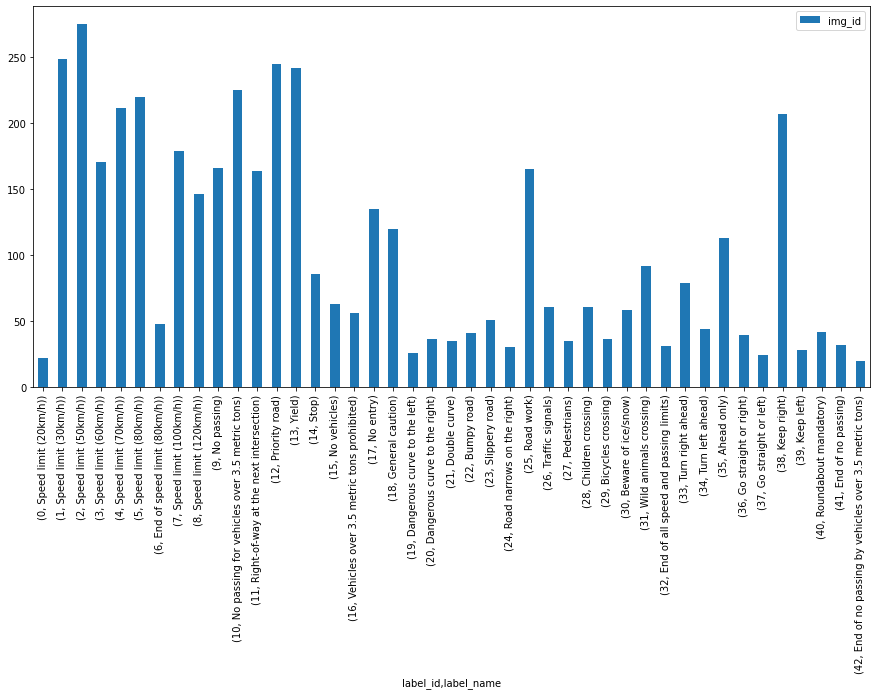

In [16]:
# Now count the number of images for each class and plot the results so that we understand the distribution
X_valid_group_by_label_count.plot(kind='bar', figsize=(15, 7))

We also observe significant imbalance in the validation set. This is honestly less of a problem as we do not train our data on it.

#### Validation Set Images Visualization

In [17]:
# Let's plot images from each of these classes
X_valid_group_by_label = X_valid_id_to_label.groupby(["label_id", "label_name"])

show_random_dataset_images(X_valid_group_by_label, X_valid)

Output hidden; open in https://colab.research.google.com to view.

The validation set seems to suffer from the same problems as the training set, where some images are extremely dark.

### Create a sample set

As we have over 30 thousand images, we do not want to try every model on the whole dataset as this would be extremely time consuming. Instead, we create _sample_ datasets for training and validation, where we copy a percentage P of both dataset.

In [18]:
X_sample_train, y_sample_train = create_sample_set(X_train_group_by_label, X_train, y_train, pct=0.33)
print("Sample training images dimensions={0}, labels dimensions={1}".format(X_sample_train.shape, y_sample_train.shape))

X_sample_valid, y_sample_valid = create_sample_set(X_valid_group_by_label, X_valid, y_valid, pct=0.33)
print("Sample validation images dimensions={0}, labels dimensions={1}".format(X_sample_valid.shape, y_sample_valid.shape))

Sample training images dimensions=(11464, 32, 32, 3), labels dimensions=(11464,)
Sample validation images dimensions=(1433, 32, 32, 3), labels dimensions=(1433,)


We can see that some images are very dark, and we should therefore look at applying a pre-processing step to brighten them if possible.

# Step 2: Design and Test a Model Architecture


## Data Pre-Processing

Minimally, the image data should be normalized so that the data has mean zero and equal variance. For image data, `(pixel - 128)/ 128` is a quick way to approximately normalize the data and can be used in this project. 

### Normalisation

In [19]:
# Normalise training set
X_train_normalised = normalise_images(X_train, X_train)

In [20]:
# Do the same for training and validation sets, using mean and standard deviation of training set
X_valid_normalised = normalise_images(X_valid, X_train) 
X_test_normalised = normalise_images(X_test, X_train) 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


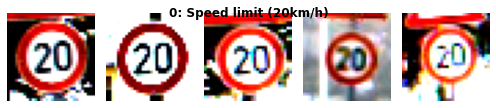

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


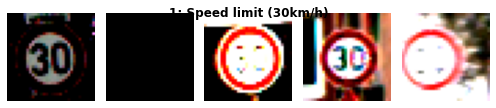

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


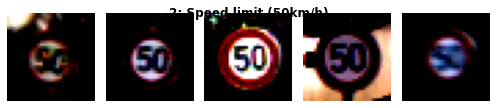

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


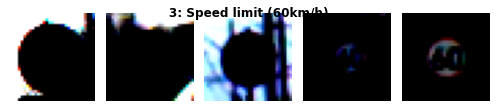

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


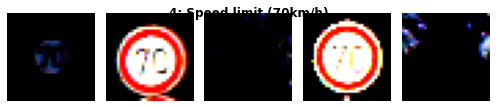

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


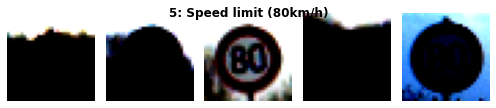

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


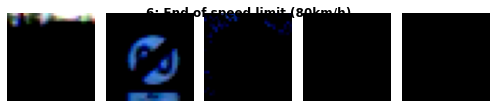

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


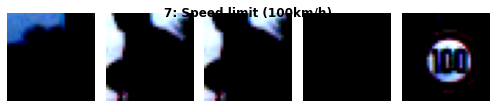

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


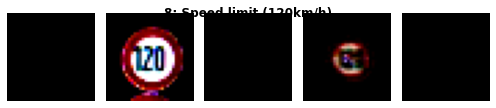

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


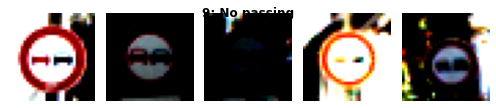

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


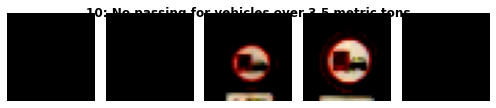

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


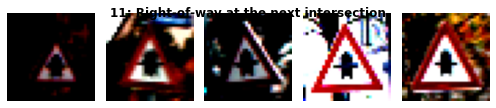

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


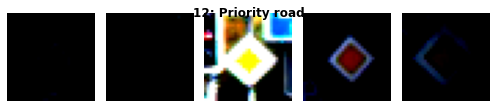

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


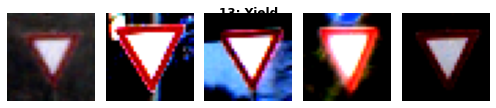

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


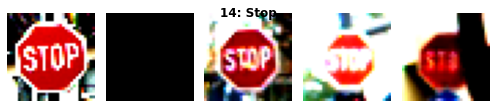

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


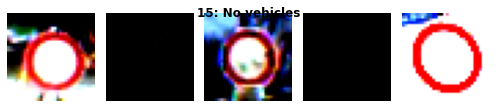

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


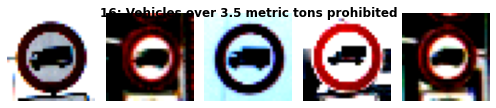

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


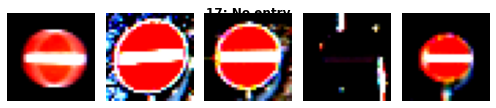

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


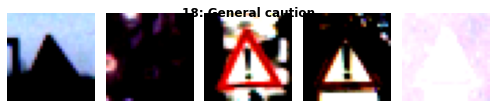

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


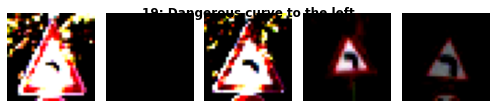

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


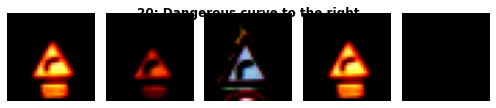

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


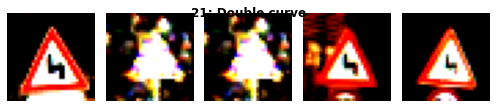

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


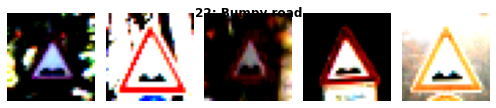

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


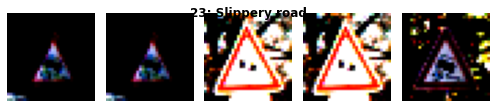

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


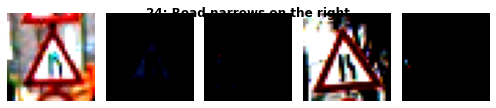

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


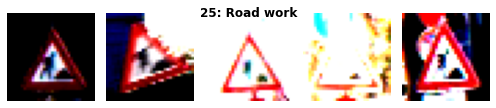

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


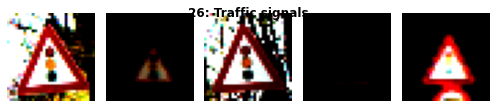

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


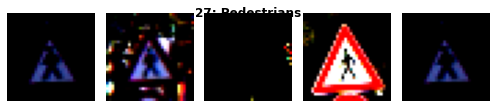

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


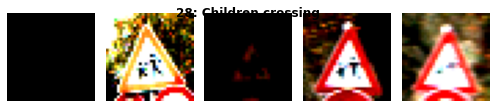

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


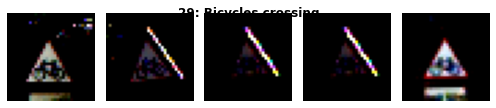

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


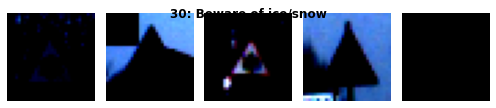

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


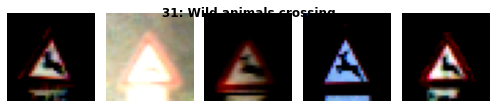

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


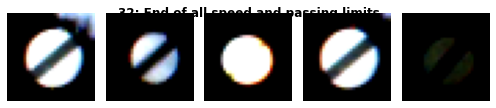

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


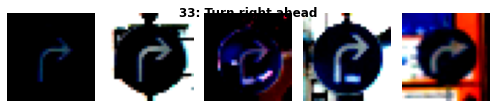

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


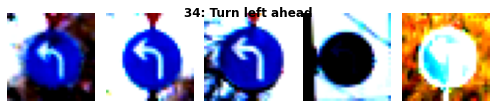

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


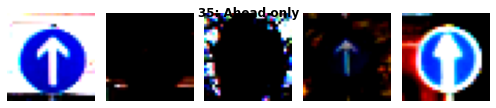

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


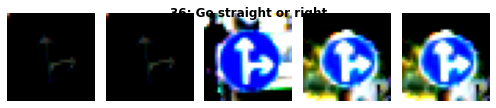

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


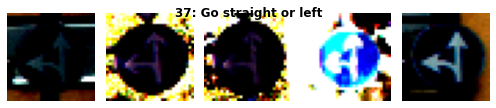

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


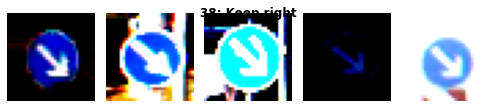

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


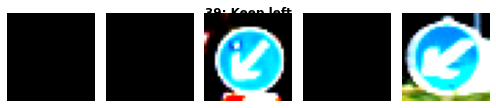

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


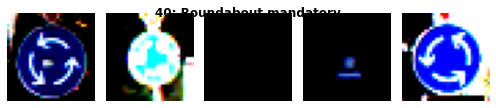

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


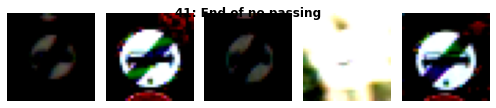

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


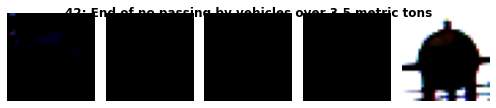

In [21]:
show_random_dataset_images(X_valid_group_by_label, X_valid_normalised)

### Grayscale

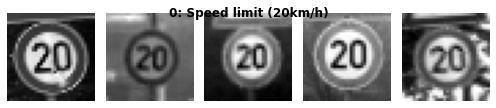

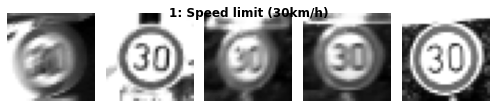

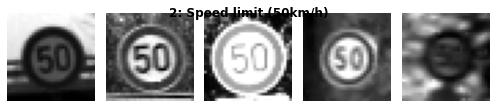

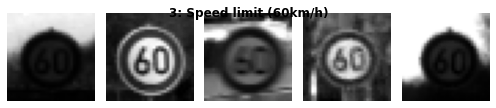

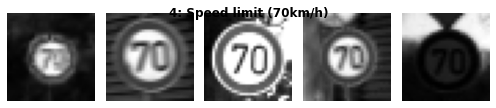

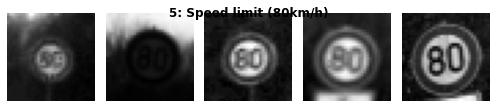

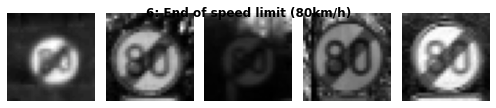

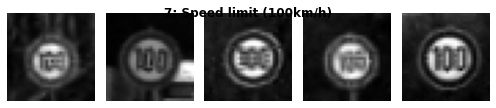

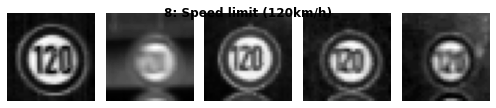

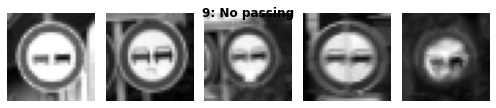

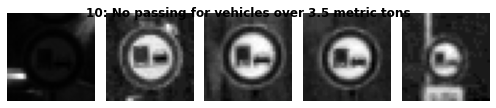

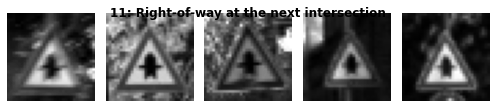

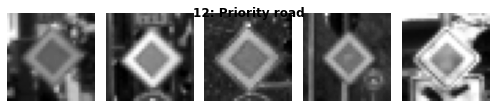

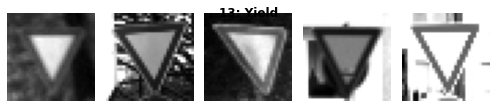

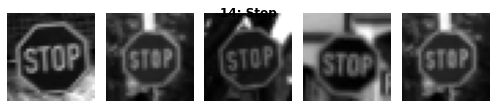

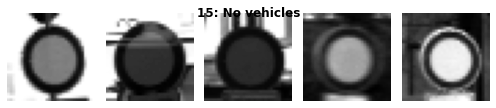

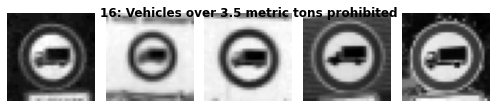

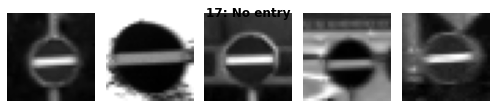

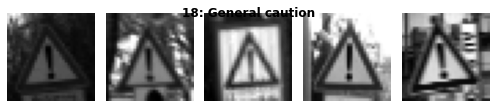

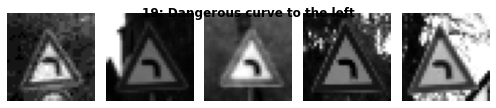

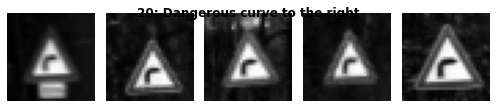

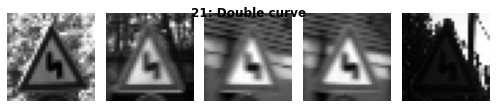

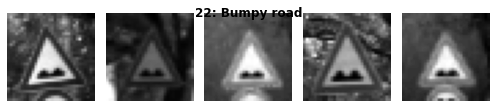

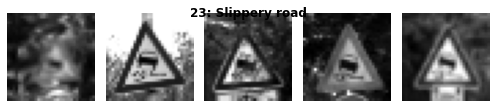

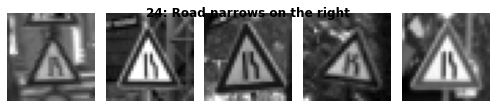

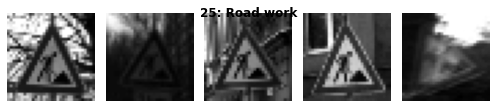

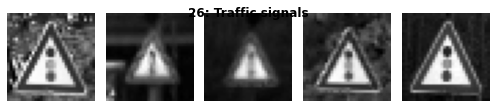

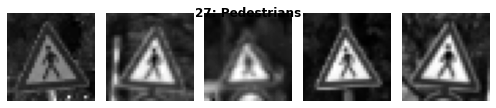

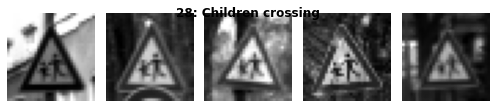

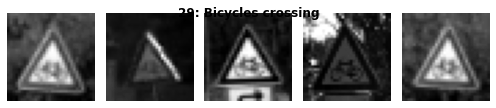

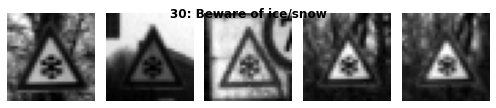

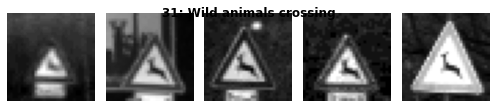

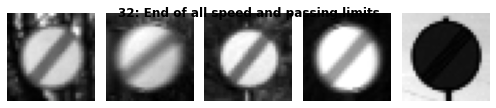

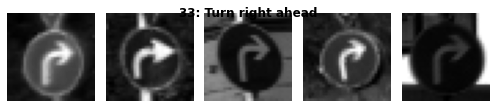

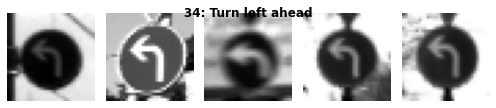

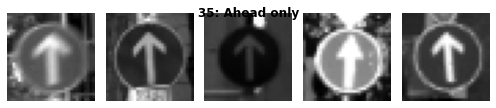

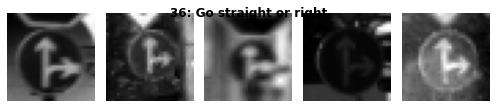

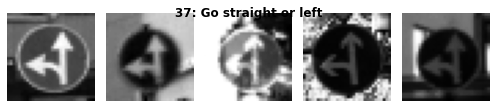

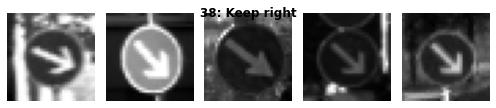

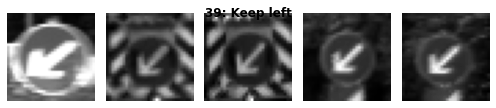

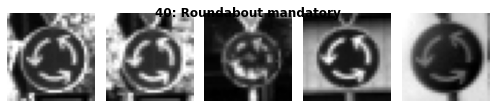

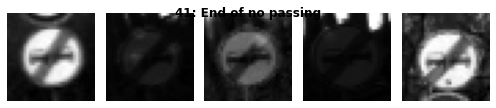

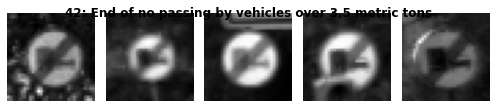

In [22]:
# Let's test our image graying features on training set
X_train_grayscale = np.asarray(list(map(lambda img: to_grayscale(img), X_train))) 
show_random_dataset_images(X_train_group_by_label, X_train_grayscale)

We can see that grayscaling somewhat improves the visibility of the images, but some of them still remain very dark. At this stage we will not address this problem.

In [23]:
# Do the same on validation set
X_valid_grayscale = np.asarray(list(map(lambda img: to_grayscale(img), X_valid))) 
#show_random_dataset_images(X_valid_group_by_label, X_valid_grayscale)

In [24]:
# Also grayscale test data
X_test_grayscale = np.asarray(list(map(lambda img: to_grayscale(img), X_test))) 
#show_image_list(X_test_grayscale[10:13], y_test[10:13], "Gray image", cols=3, fig_size=(3, 3), show_ticks=False)

## Model Architectures

In this section, we will a configurable neural network architecture where the number of layers as well as filter sizes can be modified. But first, we set up the pipeline to enable us to achieve our goal.

### Configuration and Execution Pipeline

We define the steps necessary to build a training pipeline in Tensorflow. These are defined as classes to increase flexibility.

In [25]:
class ModelConfig:
    """
    ModelConfig is a utility class that stores important configuration option about our model
    """

    def __init__(self, model, name, input_img_dimensions, conv_layers_config, fc_output_dims, output_classes, dropout_keep_pct):
        self.model = model
        self.name=name
        self.input_img_dimensions = input_img_dimensions
        
        # Determines the wxh dimension of filters, the starting depth (increases by x2 at every layer) 
        # and how many convolutional layers the network has
        self.conv_filter_size = conv_layers_config[0]
        self.conv_depth_start = conv_layers_config[1]
        self.conv_layers_count = conv_layers_config[2]


        self.fc_output_dims = fc_output_dims 
        self.output_classes = output_classes

        # Try with different values for drop out at convolutional and fully connected layers
        self.dropout_conv_keep_pct = dropout_keep_pct[0]
        self.dropout_fc_keep_pct = dropout_keep_pct[1]

In [26]:
class ModelExecutor:
    """
    ModelExecutor is responsible for executing the supplied model
    """
    def __init__(self, model_config, learning_rate=0.001):
        self.model_config = model_config
        self.learning_rate = learning_rate
    
        self.graph = tf.Graph()
        with self.graph.as_default() as g:
            with g.name_scope( self.model_config.name ) as scope:
                # Create Model operations
                self.create_model_operations()

                # Create a saver to persist the results of execution
                self.saver = tf.train.Saver()
    
    def create_placeholders(self):
        """
        Defining our placeholder variables:
            - x, y
            - one_hot_y
            - dropout placeholders
        """

        # e.g. 32 * 32 * 3
        input_dims = self.model_config.input_img_dimensions
        self.x = tf.placeholder(tf.float32, (None, input_dims[0], input_dims[1], input_dims[2]), name="{0}_x".format(self.model_config.name))
        self.y = tf.placeholder(tf.int32, (None), name="{0}_y".format(self.model_config.name))
        self.one_hot_y = tf.one_hot(self.y, self.model_config.output_classes)

        self.dropout_placeholder_conv = tf.placeholder(tf.float32)
        self.dropout_placeholder_fc = tf.placeholder(tf.float32)

    
    def create_model_operations(self):
        """
        Sets up all operations needed to execute run deep learning pipeline
        """

        # First step is to set our x, y, etc
        self.create_placeholders()

        cnn = self.model_config.model

        # Build the network -  TODO: pass the configuration in the future
        self.logits = cnn(self.x, self.model_config, self.dropout_placeholder_conv, self.dropout_placeholder_fc)
        # Obviously, using softmax as the activation function for final layer
        self.cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=self.one_hot_y, logits=self.logits)
        # Combined all the losses across batches
        self.loss_operation = tf.reduce_mean(self.cross_entropy)
        # What method do we use to reduce our loss?
        self.optimizer = tf.train.AdamOptimizer(learning_rate=self.learning_rate)
        # What do we really do in a training operation then? Answer: we attempt to reduce the loss using our chosen optimizer
        self.training_operation = self.optimizer.minimize(self.loss_operation)

        # Get the top prediction for model against labels and check whether they match
        self.correct_prediction = tf.equal(tf.argmax(self.logits, 1), tf.argmax(self.one_hot_y, 1))
        # Compute accuracy at batch level
        self.accuracy_operation = tf.reduce_mean(tf.cast(self.correct_prediction, tf.float32))

        # compute what the prediction would be, when we don't have matching label
        self.prediction = tf.argmax(self.logits, 1)
        # Registering our top 5 predictions
        self.top5_predictions = tf.nn.top_k(tf.nn.softmax(self.logits), k=5, sorted=True, name=None)

        
    def evaluate_model(self, X_data, Y_data, batch_size):
        """
        Evaluates the model's accuracy and loss for the supplied dataset. 
        Naturally, Dropout is ignored in this case (i.e. we set dropout_keep_pct to 1.0)
        """
        
        num_examples = len(X_data)
        total_accuracy = 0.0
        total_loss = 0.0
        sess = tf.get_default_session()

        for offset in range(0, num_examples, batch_size):
            batch_x, batch_y = X_data[offset:offset+batch_size], Y_data[offset:offset+batch_size]
            
            # Compute both accuracy and loss for this batch
            accuracy = sess.run(self.accuracy_operation, 
                                feed_dict={
                                    self.dropout_placeholder_conv: 1.0,
                                    self.dropout_placeholder_fc: 1.0,
                                    self.x: batch_x, 
                                    self.y: batch_y
                                           })
            loss = sess.run(self.loss_operation, feed_dict={
                                    self.dropout_placeholder_conv: 1.0,
                                    self.dropout_placeholder_fc: 1.0,
                                    self.x: batch_x, 
                                    self.y: batch_y
                                           })

            # Weighting accuracy by the total number of elements in batch
            total_accuracy += (accuracy * len(batch_x))        
            total_loss += (loss * len(batch_x))            

        # To produce a true mean accuracy over whole dataset
        return (total_accuracy / num_examples, total_loss / num_examples) 
    
    
    def train_model(self, X_train_features, X_train_labels, X_valid_features, y_valid_labels, batch_size=512, epochs=100, PRINT_FREQ=10):
        """
        Trains the model for the specified number of epochs supplied when creating the executor
        """

        # Create our array of metrics    
        training_metrics = np.zeros((epochs, 3))
        validation_metrics = np.zeros((epochs, 3))


        with tf.Session(graph = self.graph, config=tf.ConfigProto(allow_soft_placement=True, log_device_placement=True)) as sess:            
            
            sess.run(tf.global_variables_initializer())
            num_examples = len(X_train_features)


            print("Training {0} [epochs={1}, batch_size={2}]...\n".format(self.model_config.name, epochs, batch_size))

            for i in range(epochs):
                start = time.time()
                X_train, Y_train = shuffle(X_train_features, X_train_labels)
                for offset in range(0, num_examples, batch_size):
                    end = offset + batch_size
                    batch_x, batch_y = X_train[offset:end], Y_train[offset:end]
                    sess.run(self.training_operation, feed_dict={
                        self.x: batch_x, 
                        self.y: batch_y, 
                        self.dropout_placeholder_conv: self.model_config.dropout_conv_keep_pct,
                        self.dropout_placeholder_fc: self.model_config.dropout_fc_keep_pct,

                    })

                end_training_time = time.time()
                training_duration = end_training_time - start

                #computing training accuracy
                training_accuracy, training_loss = self.evaluate_model(X_train_features, X_train_labels, batch_size)            


                # Computing validation accuracy 
                validation_accuracy, validation_loss = self.evaluate_model(X_valid_features, y_valid_labels, batch_size)


                end_epoch_time = time.time()            
                validation_duration = end_epoch_time - end_training_time   
                epoch_duration = end_epoch_time - start

                if i == 0 or (i+1) % PRINT_FREQ == 0:
                    print("[{0}]\ttotal={1:.3f}s | train: time={2:.3f}s, loss={3:.4f}, acc={4:.4f} | val: time={5:.3f}s, loss={6:.4f}, acc={7:.4f}".format(
                          i+1, epoch_duration, training_duration, training_loss, training_accuracy, 
                        validation_duration, validation_loss, validation_accuracy))

                training_metrics[i] = [training_duration, training_loss, training_accuracy]
                validation_metrics[i] = [validation_duration, validation_loss, validation_accuracy]

            model_file_name = "{0}{1}.chkpt".format(models_path, self.model_config.name)
            # Save the model
            self.saver.save(sess, model_file_name)
            print("Model {0} saved".format(model_file_name))

        return (training_metrics, validation_metrics, epoch_duration)
    
    def test_model(self, test_imgs, test_lbs, batch_size=512):
        """
        Evaluates the model with the test dataset and test labels
        Returns the tuple (test_accuracy, test_loss, duration)
        """

        with tf.Session(graph = self.graph) as sess:
            # Never forget to re-initialise the variables
            tf.global_variables_initializer()

            
            model_file_name = "{0}{1}.chkpt".format(models_path, self.model_config.name)
            self.saver.restore(sess, model_file_name)

            start = time.time()
            (test_accuracy, test_loss) = self.evaluate_model(test_imgs, test_lbs, batch_size)
            duration = time.time() - start
            print("[{0} - Test Set]\ttime={1:.3f}s, loss={2:.4f}, acc={3:.4f}".format(self.model_config.name, duration, test_loss, test_accuracy))

        
        return (test_accuracy, test_loss, duration)
    
    def predict(self, imgs, top_5=False):
        """
        Returns the predictions associated with a bunch of images
        """
        preds = None
        with tf.Session(graph = self.graph) as sess:
            # Never forget to re-initialise the variables
            tf.global_variables_initializer()

            model_file_name = "{0}{1}.chkpt".format(models_path, self.model_config.name)
            self.saver.restore(sess, model_file_name)
            
            if top_5:
                preds = sess.run(self.top5_predictions, feed_dict={
                        self.x: imgs,
                        self.dropout_placeholder_conv: 1.0,
                        self.dropout_placeholder_fc: 1.0
                    })
            else:
                preds = sess.run(self.prediction, feed_dict={
                    self.x: imgs,
                    self.dropout_placeholder_conv: 1.0,
                    self.dropout_placeholder_fc: 1.0
                })
    
        return preds
    
    def show_conv_feature_maps(self, img, conv_layer_idx=0, activation_min=-1, activation_max=-1 ,
                               plt_num=1, fig_size=(15, 15), title_y_pos=1.0):
        """
        Shows the resulting feature maps at a given convolutional level for a SINGLE image
        """
        #s = tf.train.Saver()
        with tf.Session(graph = self.graph) as sess:
            # Never forget to re-initialise the variables
            tf.global_variables_initializer()
            #tf.reset_default_graph()

            model_file_name = "{0}{1}.chkpt".format(models_path, self.model_config.name)
            self.saver.restore(sess, model_file_name)
            
            # Run a prediction
            preds = sess.run(self.prediction, feed_dict={
                    self.x: np.reshape(img, [1, img.shape[0], img.shape[1], img.shape[2]]),
                    self.dropout_placeholder_conv: 1.0,
                    self.dropout_placeholder_fc: 1.0
                })

            
            var_name = "{0}/conv_{1}_relu:0".format(self.model_config.name, conv_layer_idx)
            print("Fetching tensor: {0}".format(var_name))
            conv_layer = tf.get_default_graph().get_tensor_by_name(var_name)
            
            activation = sess.run(conv_layer, feed_dict={
                            self.x: np.reshape(img, [1, img.shape[0], img.shape[1], img.shape[2]]),
                            self.dropout_placeholder_conv: 1.0,
                            self.dropout_placeholder_fc: 1.0
                            })
            featuremaps = activation.shape[-1]
            # (1, 13, 13, 64)
            print("Shape of activation layer: {0}".format(activation.shape))
            
            #fix the number of columns
            cols = 8
            rows = featuremaps // cols
            fig, axes = plt.subplots(rows, cols, figsize=fig_size)
            k = 0
            for i in range(0, rows):
                for j in range(0, cols):
                    ax = axes[i, j]
                    featuremap = k

                    if activation_min != -1 & activation_max != -1:
                        ax.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin =activation_min, vmax=activation_max, cmap="gray")
                    elif activation_max != -1:
                        ax.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmax=activation_max, cmap="gray")
                    elif activation_min !=-1:
                        ax.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin=activation_min, cmap="gray")
                    else:
                        ax.imshow(activation[0,:,:, featuremap], interpolation="nearest", cmap="gray")
                    
                    ax.axis("off")
                    k += 1
            
            fig.suptitle("Feature Maps at layer: {0}".format(conv_layer), fontsize=12, fontweight='bold', y=title_y_pos)
            fig.tight_layout()
            plt.show()
                            

#### EdLeNet

We implement simple variant LeNet by Yann Le Cun, comically named *EdLeNet*. We make the network highly configurable so that we can assess its different variants and determine which one provides the most accuracy.

In [27]:
from tensorflow.contrib.layers import flatten

def EdLeNet(x, mc, dropout_conv_pct, dropout_fc_pct):
    """
    A variant of LeNet created by Yann Le Cun
    The second parameter, which is encapsulates model configuration, enables varying the convolution filter sizes 
    as well as the number of fully connected layers and their output dimensions.
    The third and fourth parameters represent dropout placeholders for convolutional and fully connected layers respectively
    """
    
    # Used for randomly definining weights and biases
    mu = 0
    sigma = 0.1
    
    prev_conv_layer = x
    conv_depth = mc.conv_depth_start
    conv_input_depth = mc.input_img_dimensions[-1]
   
    print("[EdLeNet] Building neural network [conv layers={0}, conv filter size={1}, conv start depth={2}, fc layers={3}]".format(
        mc.conv_layers_count, mc.conv_filter_size, conv_depth, len(mc.fc_output_dims)))
    
    for i in range(0, mc.conv_layers_count):
        # layer depth grows exponentially
        conv_output_depth = conv_depth * (2 ** (i))
        conv_W = tf.Variable(tf.truncated_normal(shape=(mc.conv_filter_size, mc.conv_filter_size, conv_input_depth, conv_output_depth), 
                                              mean = mu, stddev = sigma))
        conv_b = tf.Variable(tf.zeros(conv_output_depth))
        
        conv_output = tf.nn.conv2d(prev_conv_layer, conv_W, strides=[1, 1, 1, 1], padding='VALID', name="conv_{0}".format(i)) + conv_b
        conv_output = tf.nn.relu(conv_output, name="conv_{0}_relu".format(i))
        # Traditional max 2x2 pool 
        conv_output = tf.nn.max_pool(conv_output, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
        # Apply dropout - even at the conv level
        conv_output = tf.nn.dropout(conv_output, dropout_conv_pct) 
        
        # Setting our loop variables accordingly
        prev_conv_layer = conv_output
        conv_input_depth = conv_output_depth

    
    # Flatten results of second convolutional layer so that it can be supplied to fully connected layer
    fc0   = flatten(prev_conv_layer)
    
    # Now creating our fully connected layers
    prev_layer = fc0
    for output_dim in mc.fc_output_dims:
        fcn_W  = tf.Variable(tf.truncated_normal(shape=(prev_layer.get_shape().as_list()[-1], output_dim), 
                                                 mean = mu, stddev = sigma))
        fcn_b  = tf.Variable(tf.zeros(output_dim))
        
        prev_layer   = tf.nn.dropout(tf.nn.relu(tf.matmul(prev_layer, fcn_W) + fcn_b), dropout_fc_pct)

    
    # Final layer (Fully Connected)
    fc_final_W  = tf.Variable(tf.truncated_normal(shape=(prev_layer.get_shape().as_list()[-1], mc.output_classes), 
                                                  mean = mu, stddev = sigma))
    fc_final_b  = tf.Variable(tf.zeros(mc.output_classes))
    logits = tf.matmul(prev_layer, fc_final_W) + fc_final_b
    
    return logits

## Train, Validate and Test the Model

## Histogram Equalization

We observed earlier that some of the images in the dataset were quite dark, and others blurry. We are aiming at taclking this problem in this part where we attempt to apply [histogram equalization](https://en.wikipedia.org/wiki/Histogram_equalization) techniques to improve the contrast of our images and therefore make it easier for our model to discern which class the supplied image ultimately belongs to with a higher level of confidence.
To do so, we are going to rely on OpenCV's [CLAHE](http://docs.opencv.org/3.1.0/d5/daf/tutorial_py_histogram_equalization.html) (Contrast Limiting Adaptive Histogram Equalization) function.

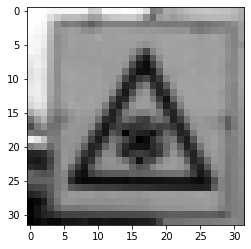

In [28]:
g_img = np.reshape(X_train_grayscale[15796], (32, 32))
plt.imshow(g_img, cmap='gray')

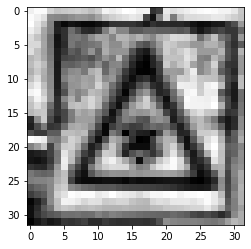

In [29]:
clahe = cv2.createCLAHE(tileGridSize=(4,4), clipLimit=40.0)
cl1 = clahe.apply(g_img)
plt.imshow(cl1, cmap='gray')

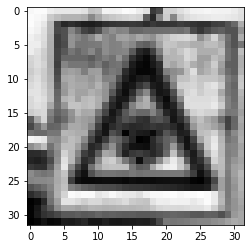

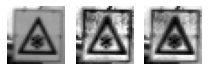

In [30]:
clahe = cv2.createCLAHE(tileGridSize=(2,2), clipLimit=15.0)
cl2 = clahe.apply(g_img)
plt.imshow(cl2, cmap='gray')
show_image_list([g_img, cl1, cl2], ["L0","L1", "l2"], "", cols=3, fig_size=(3, 3), show_ticks=False)

We choose CLAHE with grid size of 2x2 and climit limit of 15.

In [31]:
X_train_grayscale_equalized = np.asarray(list(map(lambda img: clahe.apply(np.reshape(img, (32, 32))), X_train_grayscale)))
X_valid_grayscale_equalized = np.asarray(list(map(lambda img: clahe.apply(np.reshape(img, (32, 32))), X_valid_grayscale)))
X_test_grayscale_equalized = np.asarray(list(map(lambda img: clahe.apply(np.reshape(img, (32, 32))), X_test_grayscale)))

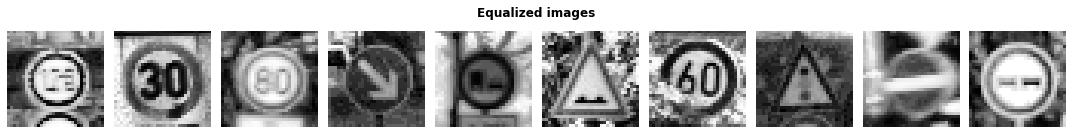

In [32]:
show_image_list(X_train_grayscale_equalized[1640:1650], y_train[1640:1650], "Equalized images", fig_size=(15, 10), cols=10, show_ticks=False)

### Model evaluation 

In [33]:
# Let's normalise our images beforehand
X_train_grayscale_equalized_normalised = normalise_images(X_train_grayscale_equalized, X_train_grayscale_equalized)
X_valid_grayscale_equalized_normalised = normalise_images(X_valid_grayscale_equalized, X_train_grayscale_equalized)
X_test_grayscale_equalized_normalised = normalise_images(X_test_grayscale_equalized, X_train_grayscale_equalized)


In [34]:
# Let's not forget to reshape our images
X_train_grayscale_equalized = np.reshape(X_train_grayscale_equalized, (X_train_grayscale_equalized.shape[0], 32, 32, 1))
X_valid_grayscale_equalized = np.reshape(X_valid_grayscale_equalized, (X_valid_grayscale_equalized.shape[0], 32, 32, 1))
X_test_grayscale_equalized = np.reshape(X_test_grayscale_equalized, (X_test_grayscale_equalized.shape[0], 32, 32, 1))

X_train_grayscale_equalized_normalised = np.reshape(X_train_grayscale_equalized_normalised, (X_train_grayscale_equalized_normalised.shape[0], 32, 32, 1))
X_valid_grayscale_equalized_normalised = np.reshape(X_valid_grayscale_equalized_normalised, (X_valid_grayscale_equalized_normalised.shape[0], 32, 32, 1))
X_test_grayscale_equalized_normalised = np.reshape(X_test_grayscale_equalized_normalised, (X_test_grayscale_equalized_normalised.shape[0], 32, 32, 1))

#### Normalised images With No Dropout

In [35]:
mc_3x3 = ModelConfig(EdLeNet, "EdLeNet_Grayscale_CLAHE_Norm_3x3", [32, 32, 1], [3, 32, 3], [120, 84], n_classes, [1.0, 1.0])
mc_5x5 = ModelConfig(EdLeNet, "EdLeNet_Grayscale_CLAHE_Norm_5x5", [32, 32, 1], [5, 32, 2], [120, 84], n_classes, [1.0, 1.0])

In [36]:
me_g_clahe_norm_3x3 = ModelExecutor(mc_3x3)
me_g_clahe_norm_5x5 = ModelExecutor(mc_5x5)

[EdLeNet] Building neural network [conv layers=3, conv filter size=3, conv start depth=32, fc layers=2]
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use keras.layers.flatten instead.
Instructions for updating:
Please use `layer.__call__` method instead.
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.

[EdLeNet] Building neural network [conv layers=2, conv filter size=5, conv start depth=32, fc layers=2]


In [37]:
(g_clahe_norm_3x3_tr_metrics, g_clahe_norm_3x3_val_metrics, g_clahe_norm_3x3_duration) = me_g_clahe_norm_3x3.train_model(X_train_grayscale_equalized_normalised, y_train, X_valid_grayscale_equalized_normalised, y_valid, epochs=100)
(g_clahe_norm_3x3_ts_accuracy, g_clahe_norm_3x3_ts_loss, g_clahe_norm_3x3_ts_duration) =  me_g_clahe_norm_3x3.test_model(X_test_grayscale_equalized_normalised, y_test)

Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device
/job:localhost/replica:0/task:0/device:XLA_GPU:0 -> device: XLA_GPU device
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5

Training EdLeNet_Grayscale_CLAHE_Norm_3x3 [epochs=100, batch_size=512]...

[1]	total=9.419s | train: time=8.354s, loss=1.0466, acc=0.7018 | val: time=1.065s, loss=1.0872, acc=0.6832
[10]	total=2.038s | train: time=1.132s, loss=0.0207, acc=0.9966 | val: time=0.906s, loss=0.0742, acc=0.9807
[20]	total=2.031s | train: time=1.129s, loss=0.0020, acc=1.0000 | val: time=0.901s, loss=0.0533, acc=0.9875
[30]	total=2.037s | train: time=1.135s, loss=0.0005, acc=1.0000 | val: time=0.902s, loss=0.0580, acc=0.9891
[40]	total=2.032s | train: time=1.134s, loss=0.0002, acc=1.0000 | val: time=0.898s, loss=0.0599, acc=0.9898
[50]	total=2.031s | train: time=1.132s, loss=0.0001, acc=1.0000 | val: time=0.899s, loss=0.062

In [38]:
(g_clahe_norm_5x5_tr_metrics, g_clahe_norm_5x5_val_metrics, g_clahe_norm_5x5_duration) = me_g_clahe_norm_5x5.train_model(X_train_grayscale_equalized_normalised, y_train, X_valid_grayscale_equalized_normalised, y_valid, epochs=100)
(g_clahe_norm_5x5_ts_accuracy, g_clahe_norm_5x5_ts_loss, g_clahe_norm_5x5_ts_duration) =  me_g_clahe_norm_5x5.test_model(X_test_grayscale_equalized_normalised, y_test)

Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device
/job:localhost/replica:0/task:0/device:XLA_GPU:0 -> device: XLA_GPU device
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5

Training EdLeNet_Grayscale_CLAHE_Norm_5x5 [epochs=100, batch_size=512]...

[1]	total=2.297s | train: time=1.386s, loss=0.7448, acc=0.7893 | val: time=0.911s, loss=0.7965, acc=0.7803
[10]	total=1.810s | train: time=1.007s, loss=0.0158, acc=0.9975 | val: time=0.803s, loss=0.0773, acc=0.9837
[20]	total=1.816s | train: time=1.000s, loss=0.0011, acc=1.0000 | val: time=0.815s, loss=0.0658, acc=0.9868
[30]	total=1.810s | train: time=1.006s, loss=0.0004, acc=1.0000 | val: time=0.804s, loss=0.0699, acc=0.9884
[40]	total=1.800s | train: time=1.006s, loss=0.0002, acc=1.0000 | val: time=0.794s, loss=0.0744, acc=0.9893
[50]	total=1.798s | train: time=0.997s, loss=0.0001, acc=1.0000 | val: time=0.801s, loss=0.078

Length of axis: (2,)


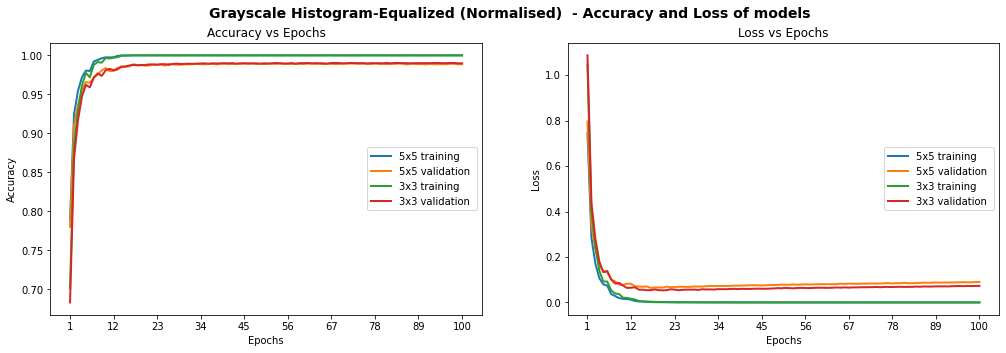

In [39]:
metrics_arr = [g_clahe_norm_5x5_tr_metrics, g_clahe_norm_5x5_val_metrics, g_clahe_norm_3x3_tr_metrics, g_clahe_norm_3x3_val_metrics]
lbs = ["5x5 training", "5x5 validation", "3x3 training", "3x3 validation "]
plot_model_results(metrics_arr, [2, 1], lbs, ["Epochs", "Epochs"], ["Accuracy", "Loss"], 
                   ["Accuracy vs Epochs", 
                    "Loss vs Epochs"],
                   "Grayscale Histogram-Equalized (Normalised)  - Accuracy and Loss of models"
                    , fig_size=(17, 5))

### Normalising images with Dropout

In [61]:
mc_3x3 = ModelConfig(EdLeNet, "EdLeNet_Grayscale_CLAHE_Norm_Take-2_3x3_Dropout_0.50", [32, 32, 1], [3, 32, 3], [120, 84], n_classes, [0.6, 0.5])

me_g_clahe_norm_take2_drpt_0_50_3x3 = ModelExecutor(mc_3x3)

(g_clahe_norm_take2_drpt_0_50_3x3_tr_metrics, g_clahe_norm_take2_drpt_0_50_3x3_val_metrics, g_clahe_norm_take2_drpt_0_50_3x3_duration)    =  me_g_clahe_norm_take2_drpt_0_50_3x3.train_model(X_train_grayscale_equalized_normalised, y_train, X_valid_grayscale_equalized_normalised, y_valid, epochs=100)
(g_clahe_norm_take2_drpt_0_50_3x3_ts_accuracy, g_clahe_norm_take2_drpt_0_50_3x3_ts_loss,    g_clahe_norm_take2_drpt_0_50_ts_3x3_duration) =  me_g_clahe_norm_take2_drpt_0_50_3x3.test_model(X_test_grayscale_equalized_normalised, y_test)

[EdLeNet] Building neural network [conv layers=3, conv filter size=3, conv start depth=32, fc layers=2]
Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device
/job:localhost/replica:0/task:0/device:XLA_GPU:0 -> device: XLA_GPU device
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5

Training EdLeNet_Grayscale_CLAHE_Norm_Take-2_3x3_Dropout_0.50 [epochs=100, batch_size=512]...

[1]	total=2.339s | train: time=1.318s, loss=3.6254, acc=0.0746 | val: time=1.021s, loss=3.6249, acc=0.0766
[10]	total=2.058s | train: time=1.133s, loss=0.9353, acc=0.6968 | val: time=0.925s, loss=0.9479, acc=0.6914
[20]	total=2.063s | train: time=1.138s, loss=0.3260, acc=0.8772 | val: time=0.926s, loss=0.3452, acc=0.8651
[30]	total=2.055s | train: time=1.127s, loss=0.1690, acc=0.9382 | val: time=0.928s, loss=0.1849, acc=0.9379
[40]	total=2.039s | train: time=1.124s, loss=0.0829, acc=0.9816 | val: time=0.

#### Analysis of 3x3 Model performance

INFO:tensorflow:Restoring parameters from ./models/EdLeNet_Grayscale_CLAHE_Norm_Take-2_3x3_Dropout_0.50.chkpt
Number of good predictions: 12319/12630
Number of bad predictions: 311/12630


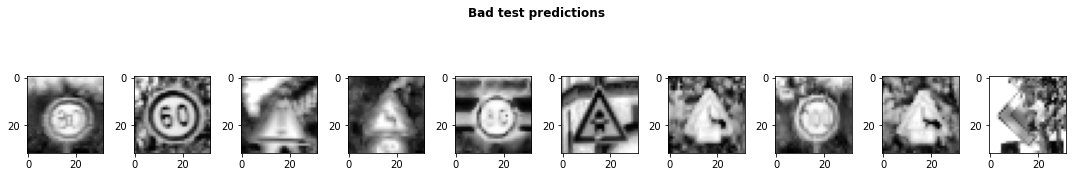

In [63]:
test_preds = me_g_clahe_norm_take2_drpt_0_50_3x3.predict(X_test_grayscale_equalized_normalised)

good_test_preds = test_preds == y_test
bad_test_preds = test_preds != y_test

bad_test_pred_imgs = X_test_grayscale_equalized[bad_test_preds]
good_test_pred_imgs = X_test_grayscale_equalized[good_test_preds]
bad_test_pred_correct_lb = y_test[bad_test_preds]
bad_test_pred_incorrect_lb = test_preds[bad_test_preds]

print("Number of good predictions: {0}/{1}".format(len(good_test_pred_imgs), len(y_test)))
print("Number of bad predictions: {0}/{1}".format(len(bad_test_pred_imgs), len(y_test)))

# We have 284 images where our prediction was incorrect. Let's visualize some of them to better understand what's going on.

count = 10
idx = np.random.randint(0, high=len(bad_test_pred_imgs), size=10)
show_image_list(bad_test_pred_imgs[idx], bad_test_pred_incorrect_lb[idx], "Bad test predictions", cols=count)

## Data Augmentation

The data presents glaring imbalance across the 43 classes. Yet it does not seem to be a crippling problem as we are able to reach very high accuracy despite the class imbalance. We also noticed that some images in the test set are distorted. We are therefore going to use data augmentation techniques in an attempt to:
1. Minimize imbalances across classes
2. Extend dataset and provide additional pictures in different lighting settings and orientations
3. Improve model's ability to become more generic
4. Improve test and validation accuracy, especially on distorted images

In [46]:
X_train_augs = X_train
y_train_augs = y_train

In [47]:
# This loop augments images per label group
for (lid, lbl), group in X_train_group_by_label:
    #print("[{0}] : {1}".format(lid, lbl))   
    group_count = group['img_id'].size
    idx = group['img_id'].values
    imgs = X_train[idx]

    
    
    # Take a different population of the subset depending on how many images we have already
    # and vary the number of augmentations depending on size of label group
    pt_spacing = 1.0
    p = 1.0
    
    n = group_count * 0.1
    
    
    if group_count > 500 and group_count < 1000:
        pt_spacing = 3.0
    elif group_count >= 1000 and group_count < 2000:
        pt_spacing = 10.0
    elif group_count >= 2000:
        pt_spacing = 20.0
    
    n = int(n)
    
    space_interval = int(group_count / pt_spacing)
    
    rand_idx = np.linspace(0, group_count, num=space_interval, endpoint=False, dtype='int')
    
    selected_rows = group.iloc[rand_idx]
    selected_img = np.array(list(map(lambda img_id: X_train[img_id], selected_rows['img_id'])))
    
    augs = augment_imgs_until_n(selected_img, n, p)
    X_train_augs = np.concatenate((X_train_augs, augs))
    y_train_augs = np.concatenate((y_train_augs, np.repeat(lid, n)))
    
print("New Augmented arrays shape: {0} and {1}".format(X_train_augs.shape, y_train_augs.shape))

New Augmented arrays shape: (38258, 32, 32, 3) and (38258,)


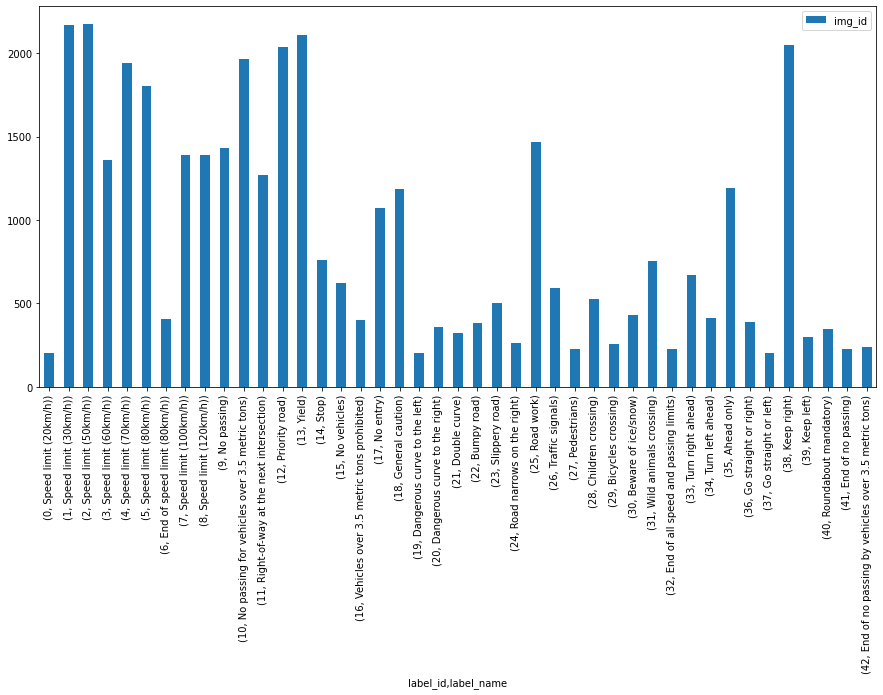

In [48]:
X_train_augs_id_to_label = group_img_id_to_lbl(y_train_augs, sign_names)
X_train_augs_group_by_label_count = group_img_id_to_lb_count(X_train_augs_id_to_label)

# Now count the number of images for each class and plot the results so that we understand the distribution
X_train_augs_group_by_label_count.plot(kind='bar', figsize=(15, 7))

We have managed to mitigate the gaping imbalance we originally observed, but it is still painfully obvious. We decided to temper our augmentation ambitions as we did not want the model to overwhelmingly learn about augmented images, to the detriment of _real_ images. That's a hard balance to strike in all fairness but we believe we have some interesting results. Now every class has at least 10% of its dataset augmented. Our assumption is that our network should now perform better. Let's put it to the test. The below shows visuals of the new dataset, with some images having been augmented by the steps above.

In [49]:
# Let's plot images from each of these classes
X_train_augs_group_by_label = X_train_augs_id_to_label.groupby(["label_id", "label_name"])

In [50]:
show_random_dataset_images(X_train_augs_group_by_label, X_train_augs)

Output hidden; open in https://colab.research.google.com to view.

## Evaluating model on augmented dataset

For this part, we will focus exclusively on grayscale images as they seem to produce better performance. Color images may exhibit close performance but as we plan to also apply histogram equalization the images must be in grayscale.

#### Grayscale Augmented Dataset

In [51]:
# First convert to grayscale
X_train_augs_grayscale = np.asarray(list(map(lambda img: to_grayscale(img), X_train_augs))) 

In [52]:
# Then histogram equalize the grayscale images
X_train_augs_grayscale_equalized  = np.asarray(list(map(lambda img: clahe.apply(np.reshape(img, (32, 32))), X_train_augs_grayscale )))

In [53]:
# Now normalise using the mean and std of the training set
X_train_augs_grayscale_equalized_normalised = normalise_images(X_train_augs_grayscale_equalized, X_train_augs_grayscale_equalized)
X_valid_augs_grayscale_equalized_normalised = normalise_images(X_valid_grayscale_equalized, X_train_augs_grayscale_equalized)
X_test_augs_grayscale_equalized_normalised = normalise_images(X_test_grayscale_equalized, X_train_augs_grayscale_equalized)


In [54]:
# Reshaping our inputs to a format that tensorflow accepts (i.e. a 4D tensor)
X_train_augs_grayscale_equalized_normalised = np.reshape(X_train_augs_grayscale_equalized_normalised, (X_train_augs_grayscale_equalized_normalised.shape[0], 32, 32, 1))
X_valid_augs_grayscale_equalized_normalised = np.reshape(X_valid_augs_grayscale_equalized_normalised, (X_valid_augs_grayscale_equalized_normalised.shape[0], 32, 32, 1))
X_test_augs_grayscale_equalized_normalised = np.reshape(X_test_augs_grayscale_equalized_normalised,   (X_test_augs_grayscale_equalized_normalised.shape[0], 32, 32, 1))

#### Dropout - Keep Fully Connected Layer Weights with p=0.5

The model *EdLeNet_Augs_Grayscale_CLAHE_Norm_Take4_3x3_Dropout_0.50* gives us our best results to date, with a test accuracy of **97.82%**. Because the loss on the training and validation sets is still relatively high, it indicates that we most likely still have room for manoeuvre, and should therefore run the model for more epochs. Therefore, we will have the current results and re-run the model for twice as many epochs and then observe results. 

In [55]:
mc_3x3 = ModelConfig(EdLeNet, "EdLeNet_Augs_Grayscale_CLAHE_Norm_Take5_3x3_Dropout_0.50", [32, 32, 1], [3, 32, 3], [120, 84], n_classes, [0.65, 0.5])
me_g_augs_clahe_norm_drpt_0_50_3x3 = ModelExecutor(mc_3x3, learning_rate=0.001)
(g_augs_clahe_norm_drpt_0_50_3x3_tr_metrics,  g_augs_clahe_norm_drpt_0_50_3x3_val_metrics, g_augs_clahe_norm_drpt_0_50_3x3_duration) = me_g_augs_clahe_norm_drpt_0_50_3x3.train_model(X_train_augs_grayscale_equalized_normalised, y_train_augs, X_valid_augs_grayscale_equalized_normalised, y_valid, epochs=100, batch_size=512)
(g_augs_clahe_norm_drpt_0_50_3x3_ts_accuracy, g_augs_clahe_norm_drpt_0_50_3x3_ts_loss,     g_augs_clahe_norm_drpt_0_50_3x3_ts_duration) =  me_g_augs_clahe_norm_drpt_0_50_3x3.test_model(X_test_augs_grayscale_equalized_normalised, y_test)


[EdLeNet] Building neural network [conv layers=3, conv filter size=3, conv start depth=32, fc layers=2]
Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device
/job:localhost/replica:0/task:0/device:XLA_GPU:0 -> device: XLA_GPU device
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5

Training EdLeNet_Augs_Grayscale_CLAHE_Norm_Take5_3x3_Dropout_0.50 [epochs=100, batch_size=512]...

[1]	total=2.663s | train: time=1.592s, loss=3.6140, acc=0.0888 | val: time=1.071s, loss=3.6130, acc=0.0950
[10]	total=2.246s | train: time=1.248s, loss=0.6394, acc=0.8141 | val: time=0.998s, loss=0.5909, acc=0.8293
[20]	total=2.237s | train: time=1.240s, loss=0.2423, acc=0.9241 | val: time=0.997s, loss=0.1949, acc=0.9406
[30]	total=2.226s | train: time=1.233s, loss=0.1232, acc=0.9706 | val: time=0.993s, loss=0.0884, acc=0.9787
[40]	total=2.225s | train: time=1.231s, loss=0.0749, acc=0.9807 | val: tim

In [56]:
(g_augs_clahe_norm_drpt_0_50_3x3_ts_accuracy, g_augs_clahe_norm_drpt_0_50_3x3_ts_loss,     g_augs_clahe_norm_drpt_0_50_3x3_ts_duration) =  me_g_augs_clahe_norm_drpt_0_50_3x3.test_model(X_test_augs_grayscale_equalized_normalised, y_test)

INFO:tensorflow:Restoring parameters from ./models/EdLeNet_Augs_Grayscale_CLAHE_Norm_Take5_3x3_Dropout_0.50.chkpt
[EdLeNet_Augs_Grayscale_CLAHE_Norm_Take5_3x3_Dropout_0.50 - Test Set]	time=0.368s, loss=0.0885, acc=0.9787


**We were running out of time here so had to interrupt the computations. Data augmentation shows a lot of promise and we will train our model on it in the future.**

## Future Improvements

While we have obtained good results, we believe that we can achieve even better performance in the future by testing more hyperparameter variations (e.g. dimensions of fully connected layers) as well as exploring novel ANN architectures such as [GoogLeNet's Inception Module](https://arxiv.org/abs/1409.4842), [Resnet](https://arxiv.org/abs/1512.03385), or [Xception](https://arxiv.org/abs/1610.02357).
